In [18]:
import numpy as np
from sklearn import linear_model
from scipy.stats import zscore
from scipy.spatial.distance import squareform,pdist
import pickle
import matplotlib.pyplot as plt

In [22]:
N_RUNS = 10

def load_data(fn):
    with open('./results/' + fn,'rb') as f:    
        data = pickle.load(f)
    return data

def gen_modelrdms(monitor=0):
    '''
    generates model rdms
    returns design matrix (z-scored lower triangular of mod rdms) & mod rdms
    '''
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    ctx = np.concatenate((np.ones((25,1)),np.zeros((25,1))),axis=0).reshape(50,1)
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    grid_rdm = squareform(pdist(gridm,metric='euclidean'))
    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    orth_rdm = squareform(pdist(orthm,metric='euclidean'))
    # parallel model 
       
    a = a.flatten()
    b = b.flatten()
    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    par_rdm = squareform(pdist(parm,metric='euclidean'))
     
    dmat = np.asarray([zscore(grid_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(orth_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(par_rdm[np.tril_indices(50,k=-1)].flatten())]).T
    rdms = np.empty((3,50,50))
    data_orig = np.empty((3,50,3))
    rdms[0] = grid_rdm
    rdms[1] = orth_rdm
    rdms[2] = par_rdm    
    data_orig[0,:,:] = gridm 
    data_orig[1,:,:] = orthm 
    data_orig[2,:,:] = parm   
    return rdms,dmat,data_orig

def stats_fit_rdms(dmat,mlp_rdms):
    '''
    regresses lower triangular of model rdms against the design 
    matrix of model rdms at a single run level
    '''
    regr = linear_model.LinearRegression()
    #n_runs = mlp_outputs.shape[0]    
    coeffs = np.empty((N_RUNS,dmat.shape[1]))
    for ii in range(N_RUNS):    
        #rdm = squareform(pdist(mlp_outputs[ii,:,:].T,metric='euclidean'))
        rdm = mlp_rdms[ii,:,:]
        y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
        regr.fit(dmat,y)
        coeffs[ii,:] = np.asarray(regr.coef_)
    return coeffs
  
def compute_rdm_fits(file_names):
    '''
    wrapper that loops over simulation files 
    and performs rdm regression for each individual simulation
    '''
    _,dmat,_ = gen_modelrdms()
    modelfits = np.empty((len(file_names),N_RUNS,dmat.shape[1]))
    for ii,fn in enumerate(file_names):
        data = load_data(fn)
        modelfits[ii,:,:] = stats_fit_rdms(dmat,data[5]) #5 gives second layer fits and 4 gives 1st layer fits
    return modelfits
def plot_modelfits(file_names,title_strings,model_labels = ['grid','orthogonal','parallel']):
    '''
    wrapper that loops over individual simulation files,
    regresses neural rdms against model rdms 
    and creates one figure with standardised betas per simulation 
    (mean + sem across individual runs)
    '''
    fits = compute_rdm_fits(file_names)
    for ii in range(fits.shape[0]):
        f_m = np.mean(fits[ii,:,:],0)
        f_e = np.std(fits[ii,:,:],0)/np.sqrt(N_RUNS)
        plt.figure()
        plt.bar(np.arange(len(f_m)),f_m,yerr=f_e)
        plt.xticks(ticks=np.arange(0,len(model_labels)),labels=model_labels,fontsize=14)
        plt.ylabel('parameter estimate (a.u.)',fontsize=14)
        plt.xlabel('Model RDM',fontsize=14)
        plt.title(title_strings[ii])

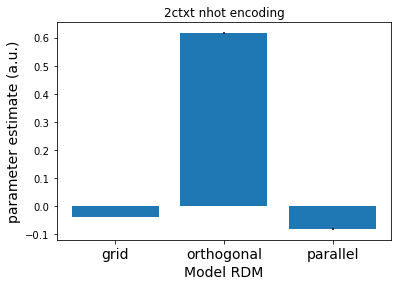

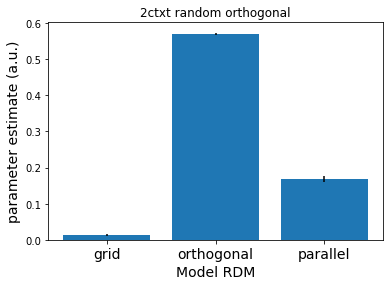

In [23]:
file_names = ['2ctxt_nhot', '2ctxt_randortho']
title_strings = ['2ctxt nhot encoding', '2ctxt random orthogonal']        
plot_modelfits(file_names,title_strings)